CAP6618 Spring 2018
Assignment 3
Christian Garbin

This notebook uses scikit-learn's ```KNeighborsClassifier``` to classify digits from the MNIST dataset. ```KNeighborsClassifier``` was chosen based on the experiments detailed in the accompanying report.

The code in this notebook is mostly adapted from the assignment notebook, which in turn was based on the code in A. Géron's "Hands-On Machine Learning with Scikit-Learn and TensorFlow".

**This notebook assumes Python 3**.

# Organization

This notebook is organized in these sections, in the order they appear:

1. Setup of global imports and parameters
2. Load and inspect the dataset
3. Training and evaluation of the selected classifier, with the final hyperparameters
4. Tuning of the selected classifier to choose hyperparameters

Logically section 4 has to be done before section 3. However, showing training and evaluation of the final classifier first resulted in a better (IMO) flow of the notebook. It makes the pipeline more visible, without adding the distraction of tuning. Once the pipeline is visible, we can layer on top of it the "branches", such as the tuning part.

# Setup

Libraries and Jupyter global configuration options.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

To make the notebook reproducible.

In [2]:
np.random.seed(42)

# MNIST dataset

Load and split the MNIST dataset.

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [ ]:
X, y = mnist["data"], mnist["target"]

The MNIST dataset is already split into train and test set. The first 60,000 samples are the train set, the last 10,000 are the test set. It has to be split this way because of how the dataset was created. Do **not** shuffle it first. Refer to [LeCun's page](http://yann.lecun.com/exdb/mnist/) for details.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle the train set because some classifiers work better with shuffled data. It's mostly needed for classifiers that can get stuck in a local minimum ([reference](https://stats.stackexchange.com/a/311318)), which is not the case with the current classifier. Added here in case this notebook is updated to use another classifier.

In [ ]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Visualizing the dataset

A visualization of the MNIST dataset,

TBD........

1. Are all classes equally represented? Histogram.
1. Visualize some digits.

The most basic check to perform in a data set is class imbalance.

The histograms below plots the number of occurrences of each digit in the train and test set.

We can see that the data set is generally well balanced. Some digits are more represented than others, but not by a large margin. We can also see than the train and test set are balanced between them, with similar digit frequencies.

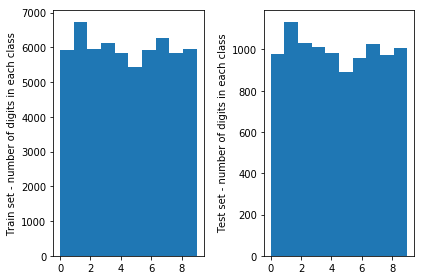

In [ ]:
plt.figure()
plt.subplot(121)
plt.hist(y_train)
plt.ylabel('Train set - number of digits in each class')
plt.subplot(122)
plt.hist(y_test)
plt.ylabel('Test set - number of digits in each class')
plt.tight_layout()
plt.show()

# Training and evaluating

In this section the classifier is trained and evluated. The following sections tune the classifier.

## Training

Using `KneighborsClassifier` based on its combination of train time, test time and accuracy.

Note that to achieve a manageable test time we are using `n_jobs=-1`, to parallelize the work as much as possible.

Also note that the time spent in `.fit(...)` for this classifier is deceiving. This classifier does not have a proper training phase. All the work is done at test time (e.g. in `cross_val_score`).

In [ ]:
%%time

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

fit_results = clf.fit(X_train, y_train)
print(fit_results)  # Need to explicitly print results because of %%time

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
CPU times: user 17.7 s, sys: 84.4 ms, total: 17.7 s
Wall time: 17.6 s


## Evaluating

Now perform a thorough evaluation with cross-validation. 

This will take a while to run (about 12 minutes on a MacBook i7 2.9 GHz).

In [ ]:
%%time
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)

Go into details of performance with a confusion matrix.

In [ ]:
%%time

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Predict every single instance in the training data
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

Visualizing the confusion matrix as a heatmap.

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The picture above gives a general idea of how well each number is classified (lighter colors = higher values = better classification). For example, the digit one is generally classified correctly, while the digit eight has more classification errors.

Confirming the visual inspection with some math:

In [ ]:
print("Digit one accuracy:   {}".format(conf_mx[1][1]/sum(conf_mx[1])))
print("Digit eight accuracy: {}".format(conf_mx[8][8]/sum(conf_mx[8])))

To see where the misclassifications happen we will remove the diagonal (correct classifications).

In [ ]:
# Normalize each row so one class doesn't dominate the values, skewing the heatmap
# This is not strictly necessary in this case because MNIST classes are well-balanced
# It's good practice nevertheless
row_sums = conf_mx.sum(axis=1, keepdims=True)
conf_mx_misclassifications = conf_mx / row_sums

# Remove correct classifications (leaves only misclassifications in the matrix)
np.fill_diagonal(conf_mx_misclassifications, 0)  

plt.matshow(conf_mx_misclassifications, cmap=plt.cm.gray)
plt.show()

In this matrix lighter colors = higher values = higher misclassification ratios.

The brighest spot happens in the intersection of digit 4 (row) and digit 9 (column). That means the classifier is classifying a (relatively) large number of 4s as 9s.

There is also a bright (although not as bright) spot in the intersection of digit 9 (row) and digit 4 (column), indicating that some 9s are misclassified as 4s.

Show examples of 4s and 9s that are correctly and incorrectly classified.

First, find the samples that are correctly and incorrecly classified.

In [ ]:
cl_a, cl_b = 4, 9

# All cl_a digits that are correctly classified (predicted)
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]

# All cl_a digits that are mistakenly classified as cl_b
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]

# All cl_b digits mistakenly classified as cl_a
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# All cl_b digits that are correctly classified
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

Now plot them. The plot below will show a sample of 4s and 9s as:

|Classifed as 4|Classified as 9|
|----|----|
| 4s correctly classified as 4s | 4s incorrecly classified as 9s |
| 9s incorrectly classified as 4s | 9s correctly classified as 9s |


In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

TODO: analysis

### Accuracy on the test set

In [ ]:
%%time
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)  # Need to explicitly print because of %%time

# Tuning

This section covers two aspects of tuning:

- Feature manipulation, more specifially, feature normalization (scaling).
- Hyperameters, i.e. parameters that affect the behavior of the classifier.

## Feature normalization (scaling)

Before trying any tuning, we need to check if normalizing the features has any effect in the classifier.

The calculations used by some classifiers can be affected by large differences in feature values.

KNN uses the feature values to calculate distances between samples. Because there is a large variance of values between pixels in an MNIST sample (from 0 to 255), we will check if normalizing the samples affect the KNN algorithm by scaling the images.

The tests below show that accuracy decreases when features are scaled (somewhat surprinsigly - to be investigated later). 

In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

scores = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(scores)

## Hyperparameters

Two important parameters for a KNN classifier are

- Number of neighbors to include in the distance (similarity) calculations - the `n_neighbors` parameter
- How the distance between two samples is calculated - `metric` parameter

In this section we will try different values for these parameters.

### Number of neighbors

The tests below show that

* Decreasing the number of neighbors does not affect the accuracy by much.
* Increasing the number of neighbors lowers the accuracy.
* In both cases the test time is about the same. This is somewhat surprising, since adding more neighbors would increase the time to calculate the distance. However, in this case the number of features (784 pixels per image) and the large number of samples likely dominate the run time (dimensionality reduction would make a difference here).

Therefore we will keep using a relative small, but not too small, number of neighbors.

In [ ]:
%%time

clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)

In [ ]:
%%time

clf = KNeighborsClassifier(n_neighbors=30, n_jobs=-1)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)

### Distance algorithm (metric)

For this hyperparameter tuning we attempted to use "Manhattan" as the distance (the default value, used above, is Euclidean distance). This measure was used because [this article](https://arxiv.org/pdf/1708.04321.pdf) shows in table 1 that the Manhattan distance often performs well (although the tests are not necessarily in the same domain, of image classification).

The test below show that average accuracy decreases by a small margin and the test time remains about the same.

Therefore we will keep using Euclidean distance (the default value) for the distance calculation.

In [ ]:
%%time

clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, metric="manhattan")
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)